# New York City Taxi Fare Prediction

## Team member：
### Haoun Guo          hg1483
### Da Cai             dc4069
### Naisheng Zhang     nz862

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


## Step 1 : Data load and clean

In [2]:
TRAIN_PATH = '../input/train.csv'
TEST_PATH = '../input/test.csv'
SUBMISSION_NAME = 'submission.csv'
DATASET_SIZE = 200000
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE, dtype=datatypes, usecols=[1,2,3,4,5,6])
test = pd.read_csv(TEST_PATH)
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764


## step 2: Data clean

### After analysis of data, we need to remove some noisy from data.
* Lats and lons that do not belong to New York.
* Negative fare.
* Fare greater than 250 (this seems to be noisy data).
* Rides that begin and end in the same location.

In [3]:
def clean(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df
train = clean(train)

## step 3.1 : Time features


* * Year, Month, Day, Hour, Weekday
* * Night (between 16h and 20h, from monday to friday)
* * Late night (between 20h and and 6h)

In [4]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0
def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0    
def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    return df

## step 3.2 : Coordinate features

* * Latitude difference (difference from pickup and dropout latitudes)
* * Longitude difference (difference from pickup and dropout longitudes)

In [5]:
def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)
    return df

## step 3.3 : Distances features

In [6]:
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    return df

## step 4 : Process data

In [7]:
train = add_time_features(train)
test = add_time_features(test)
add_coordinate_features(train)
add_coordinate_features(test)
train = add_distances_features(train)
test = add_distances_features(test)
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,-73.844315,40.721317,-73.841614,40.712276,2009,6,15,17,0,1,0,0.009041,-0.002701,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,-74.016045,40.711304,-73.979271,40.782005,2010,1,5,16,1,1,0,-0.070702,-0.036774,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2011,8,18,0,3,0,1,0.010708,0.008507,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,-73.987129,40.733143,-73.991570,40.758091,2012,4,21,4,5,0,1,-0.024948,0.004440,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,-73.968094,40.768009,-73.956657,40.783764,2010,3,9,7,1,0,0,-0.015755,-0.011436,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


In [8]:
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns + ['key', 'passenger_count'], axis=1)

# peek data
train_clean.head()

,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,2009,6,15,17,0,1,0,0.009041,-0.002701,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,2010,1,5,16,1,1,0,-0.070702,-0.036774,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,2011,8,18,0,3,0,1,0.010708,0.008507,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,2012,4,21,4,5,0,1,-0.024948,0.004440,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,2010,3,9,7,1,0,0,-0.015755,-0.011436,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


## step 5 : Split data in train and validation

In [9]:
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)
# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [10]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## step 6 : Create Model

In [11]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.001
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
adam = optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.


## step 7 : Training Model

In [12]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 174183 samples, validate on 19354 samples
Epoch 1/20
174183/174183 [==============================] - 8s 44us/step - loss: 112.8801 - mean_absolute_error: 8.6156 - val_loss: 54.1128 - val_mean_absolute_error: 6.0884
Epoch 2/20
174183/174183 [==============================] - 6s 36us/step - loss: 23.3974 - mean_absolute_error: 2.8099 - val_loss: 19.4781 - val_mean_absolute_error: 2.3227
Epoch 3/20
174183/174183 [==============================] - 6s 36us/step - loss: 17.6263 - mean_absolute_error: 2.1492 - val_loss: 30.2136 - val_mean_absolute_error: 3.4657
Epoch 4/20
174183/174183 [==============================] - 6s 36us/step - loss: 17.0522 - mean_absolute_error: 2.1193 - val_loss: 40.1279 - val_mean_absolute_error: 4.2522
Epoch 5/20
174183/174183 [==============================] - 6s 36us/step - loss: 16.6406 - mean_absolute_error: 2.0951 - val_loss: 22.0725 - val_mean_absolute_error: 2.1854
Epoch 6/20
174183/174183 [=========

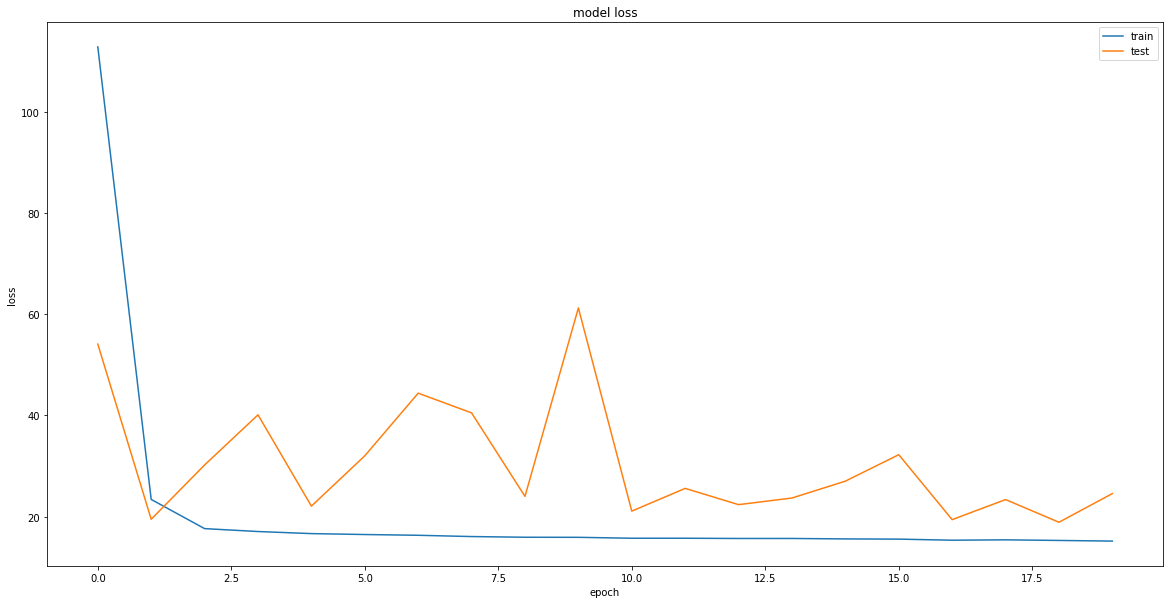

In [13]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
prediction = model.predict(test_scaled, batch_size=128, verbose=1)

9914/9914 [==============================] - 0s 30us/step


In [15]:
def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')
output_submission(test, prediction, 'key', 'fare_amount', SUBMISSION_NAME)

Output complete
